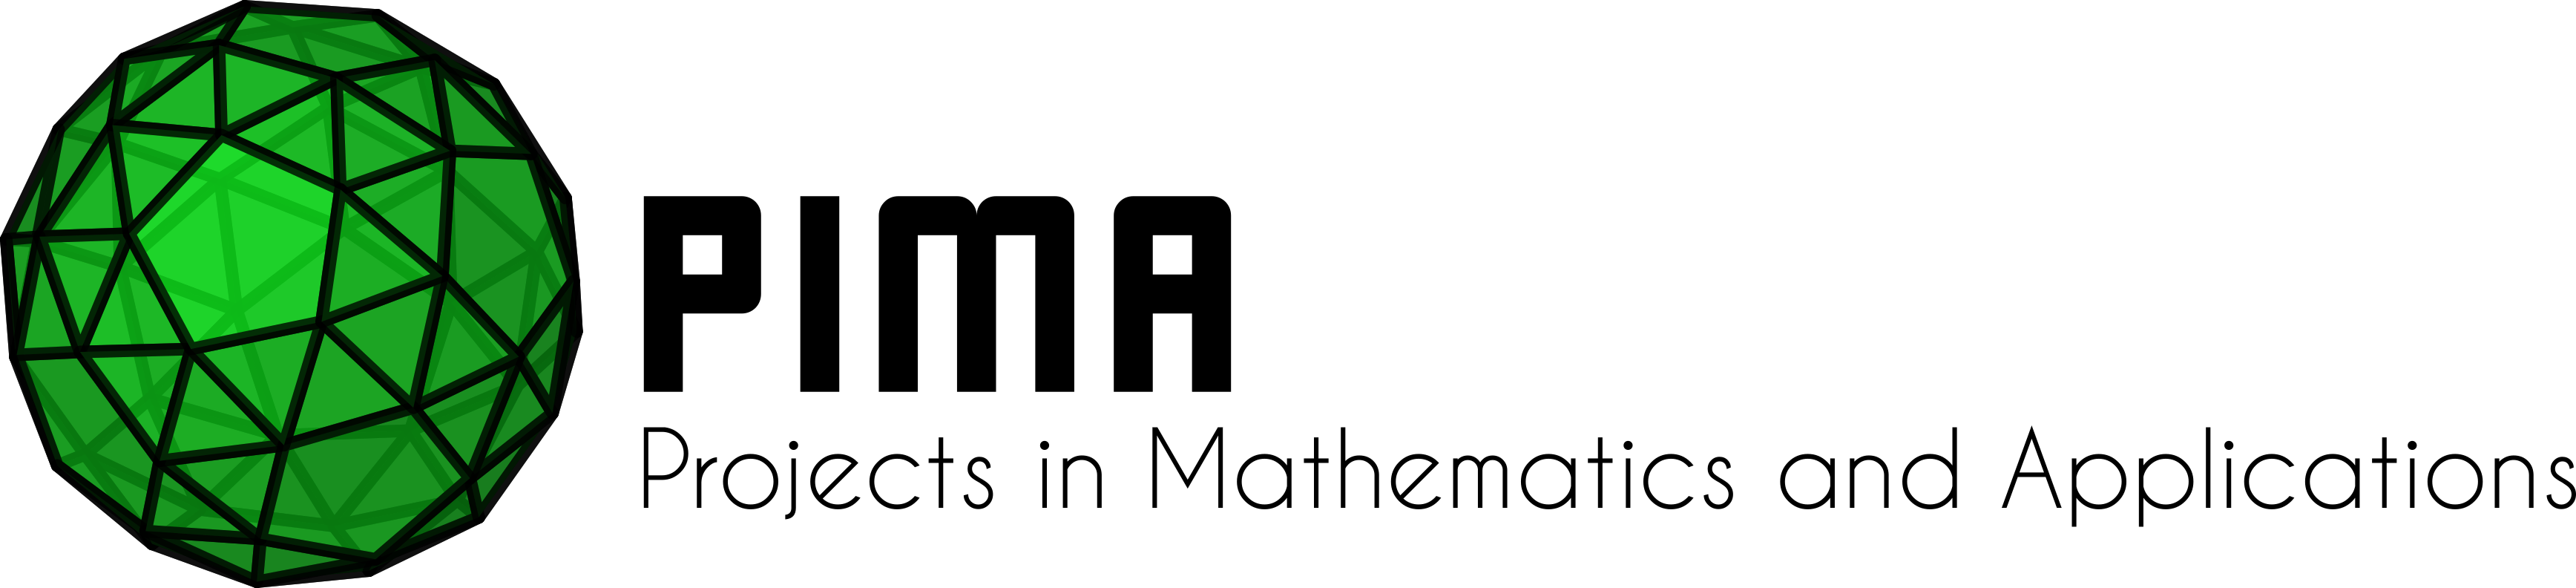

# Chuẩn bị trình chấm bài và thông tin học viên

In [1]:
import shutil
import subprocess
import sys

# # Clean up old folders if they exist
# shutil.rmtree("PiMA-GenAI-Grader", ignore_errors=True)
# shutil.rmtree("grader_homework_3", ignore_errors=True)

# # Clone the GitHub repo
# subprocess.run(["git", "clone", "https://github.com/vongvinhtoan/PiMA-GenAI-Grader.git"], check=True)

# # Move the folder
# shutil.move("PiMA-GenAI-Grader/grader_homework_3", "./grader_homework_3")

# Install requirements
subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "./grader_homework_3/requirements.txt", "--quiet"])

print("")


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


# Import các thư viện

In [2]:
from typing import *
import numpy as np
from tqdm import tqdm

T = TypeVar("T")

# Giới thiệu bài tập

Trong bài tập về nhà lập trình tuần này, chúng ta sẽ sử dụng ngôn ngữ lập trình Python để cài đặt 2 thuật toán lấy mẫu ngẫu nhiên của một phân phối $p(\mathbf x)$. Tuy nhiên trong một thiết lập bài toán, ta không có thông tin toàn vẹn về phân phối $p(\mathbf x)$ mà chỉ có một hàm $f(\mathbf x)$ sao cho $p(\mathbf x) \propto f(\mathbf x)$ hay $p(\mathbf x) = \frac{f(\mathbf x)}{Z}$ với $Z=\int f(\mathbf x) d\mathbf x$ là hằng số chuẩn hóa.

Tuy nhiên, để lấy mẫu ngẫu nhiên từ phân phối $p(\mathbf x)$, ta cần biết giá trị của $Z$, điều này có thể rất khó khăn hoặc không thể thực hiện được. Do đó, trong bài tập này, chúng ta sẽ sử dụng 2 thuật toán lấy mẫu ngẫu nhiên là Metropolis-Hastings (MH) và Metropolis-adjusted Langevin algorithm (MALA) để lấy mẫu ngẫu nhiên từ phân phối $p(\mathbf x)$ mà không cần biết giá trị của $Z$.

Hơn nữa, vì thuật toán MALA sử dụng gradient của hàm $f(\mathbf x)$, bài tập này sẽ yêu cầu bạn cài đặt một hàm gradient cho hàm $f(\mathbf x)$ ở [Bài tập 2](#bài-tập-2).

Như bài tập coding trước, trong Notebook này sẽ xuất hiện các dòng code chú thích bắt đầu bằng cụm từ `TODO` kèm theo yêu cầu, nhiệm vụ của bạn là hoàn thành các yêu cầu đó.

Bài tập về nhà lập trình tuần có **3** bài tập.

# Bài tập 1

### Import trình chấm

In [3]:
from grader_homework_3.grade_p1 import hidden_function, plot_samples

### Nội dung

Trong bài tập này, học viên được yêu cầu hoàn thành hàm `MHSampler.sample()` trong lớp `MHSampler` để thực hiện thuật toán Metropolis-Hastings nhằm lấy mẫu ngẫu nhiên từ phân phối $p(\mathbf x)$ tỷ lệ thuận với hàm ẩn `hidden_function(x, y)` được định nghĩa ẩn trong trình chấm.

Các phần cài đặt về tham số truyền vào đã được thực hiện sẵn, học viên có thể thay đổi các thiết lập của lớp `MHSampler` tùy ý, tuy nhiên điều này không được khuyến khích nếu không cần thiết.

Các đặc tính của hàm `hidden_function(x, y)` được định nghĩa như sau:
- Hàm này nhận vào 2 tham số đầu vào là `x` và `y` là các giá trị thực.
- Hàm này trả về một giá trị thực là giá trị của hàm ẩn tại điểm $(x, y)$.
- Hàm có giá trị đảm bảo bằng 0 tại các điểm nằm ngoài $[0, 1036) \times [0, 777)$.

<div style='background-color: #fff8dc; padding: 15px; border-radius: 5px; margin-bottom: 20px; color: black; border-left: 5px solid orange;'>    
    <h3 style='margin: 0; color: orange;'>💡 Gợi ý</h2>
    <p>Hãy suy nghĩ đến sự tồn tại của tham số <code>is_symmetric</code>, liệu nó có thể giản lược được cài đặt gốc của MH không?</p>
</div>

### Cài đặt Metropolis-Hastings sampler

In [4]:
class MHSampler(Generic[T]):
    def __init__(
        self,
        x0: T,
        q_sampler: Callable[[T], T],
        f: Callable[[T], float],
        q: Callable[[T, T], float] = None,
        is_symmetric: bool = False,
    ):
        """
        Metropolis-Hastings Sampler
        Thực hiện lấy mẫu từ phân phối mục tiêu $p(x)$ thông qua phân phối đề xuất $q(x'|x)$

        Parameters
        ----------
        x0 : T
            Trạng thái khởi tạo được lấy mẫu từ phân phối tiền nghiệm
        q_sampler : (T) -> T
            Hàm lấy mẫu từ phân phối đề xuất
        f : (T) -> float
            Hàm tỷ lệ thuận với hàm mật độ xác suất mục tiêu $p(x)$
        q : (T, T) -> float, optional
            Hàm xác suất của phân phối đề xuất, nếu `is_symmetric` là True thì không cần thiết
        is_symmetric : bool, optional
            Nếu bằng True nghĩa là $q(x'|x) = q(x|x')$, thì không cần truyền vào hàm `q`, mặc định là False
        """
        self.x_current = x0
        self.q_sampler = q_sampler
        self.q = q
        self.f = f
        self.is_symmetric = is_symmetric

    def burn_in(self, steps: int) -> None:
        """
        Thực hiện bước "burn-in" để loại bỏ các mẫu không cần thiết

        Parameters
        ----------
        steps : int
            Số bước "burn-in" cần thực hiện
        """
        for _ in tqdm(range(steps), desc='Burning in'):
            self.sample()

    def sample(self) -> T:
        x_current = self.x_current
        x_proposed = np.array(self.q_sampler(x_current))
        f_current = self.f(x_current)
        f_proposed = self.f(x_proposed)

        if self.is_symmetric:
            alpha = min(1, f_proposed / f_current) if f_current > 0 else 0
        else:
            q_current_given_proposed = self.q(x_proposed, x_current)
            q_proposed_given_current = self.q(x_current, x_proposed)
            alpha = min(1, (f_proposed * q_current_given_proposed) / (f_current * q_proposed_given_current)) if f_current > 0 and q_proposed_given_current > 0 else 0

        u = np.random.uniform(0, 1)
        if u < alpha:
            self.x_current = x_proposed
        return self.x_current

### Thiết lập lấy mẫu

In [5]:
# Khởi tạo Metropolis-Hastings Sampler
std = 200
mh_sampler = MHSampler[np.ndarray](
    x0           = np.array([500, 350]),
    q_sampler    = lambda x: (x[0] + np.random.normal(0, std), x[1] + np.random.normal(0, std)),
    f            = lambda p: hidden_function(*p),
    # q            = lambda x, y: np.exp(-((x[0]-y[0])**2 + (x[1]-y[1])**2) / (2 * std**2)),
    is_symmetric = True
)

# Pha "burn-in"
mh_sampler.burn_in(1000)

# Pha lấy mẫu
p1_samples = [
    mh_sampler.sample()
    for _ in tqdm(range(1_000_000), desc='Metropolis-Hastings Sampling')
]

Metropolis-Hastings Sampling: 100%|██████████| 1000000/1000000 [00:02<00:00, 338757.97it/s]


### Vẽ biểu đồ nhiệt của các điểm đã lấy mẫu

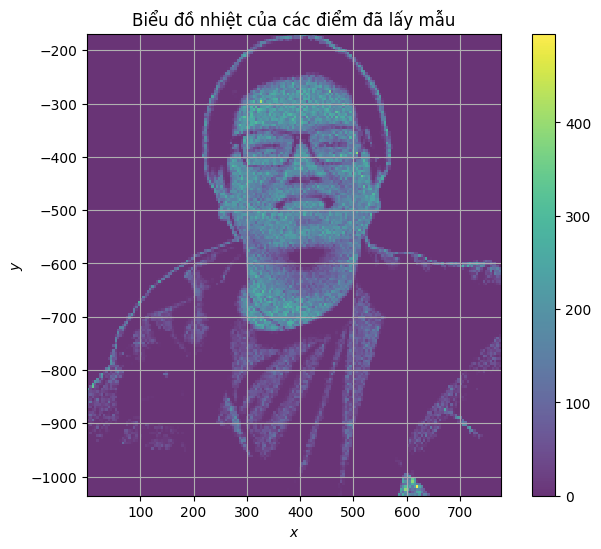

In [6]:
plot_samples(p1_samples)

_Who's that pokemon?_

# Bài tập 2

### Import trình chấm

In [7]:
from grader_homework_3.grade_p2 import (
    plot_function_conture,
    plot_function_derivative_vector_field,
    test_function_contour,
    test_function_derivative_vector_field,
)

### Nội dung

Bài tập này sẽ yêu cầu học viên chuẩn bị hàm $f: \mathbb{R}^2 \to \mathbb{R}$ và hàm gradient của nó để sử dụng trong [Bài tập 3](#bài-tập-3).

#### Tổng quan về hàm $f(\mathbf x)$

$$
f(x, y) = \sin^2\left(3\exp\left\{-\frac{x^2+y^2+xy}{4}\right\}\right) + \sin^2\left(3\exp\left\{-\frac{x^2+y^2-xy}{4}\right\}\right)
$$

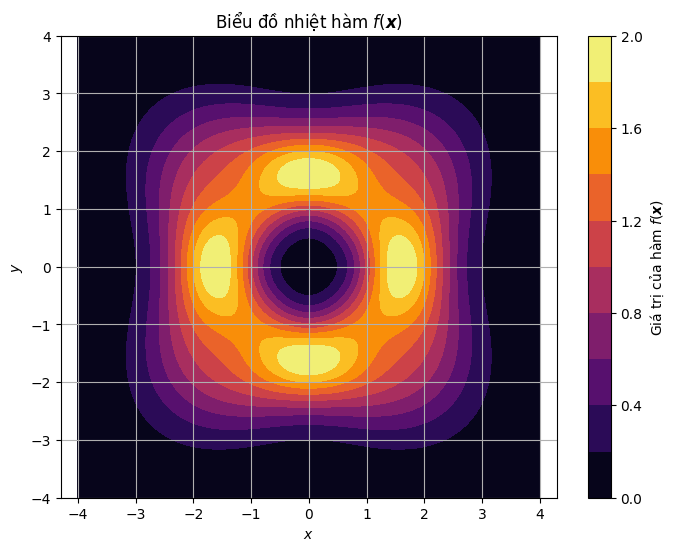

In [8]:
plot_function_conture()

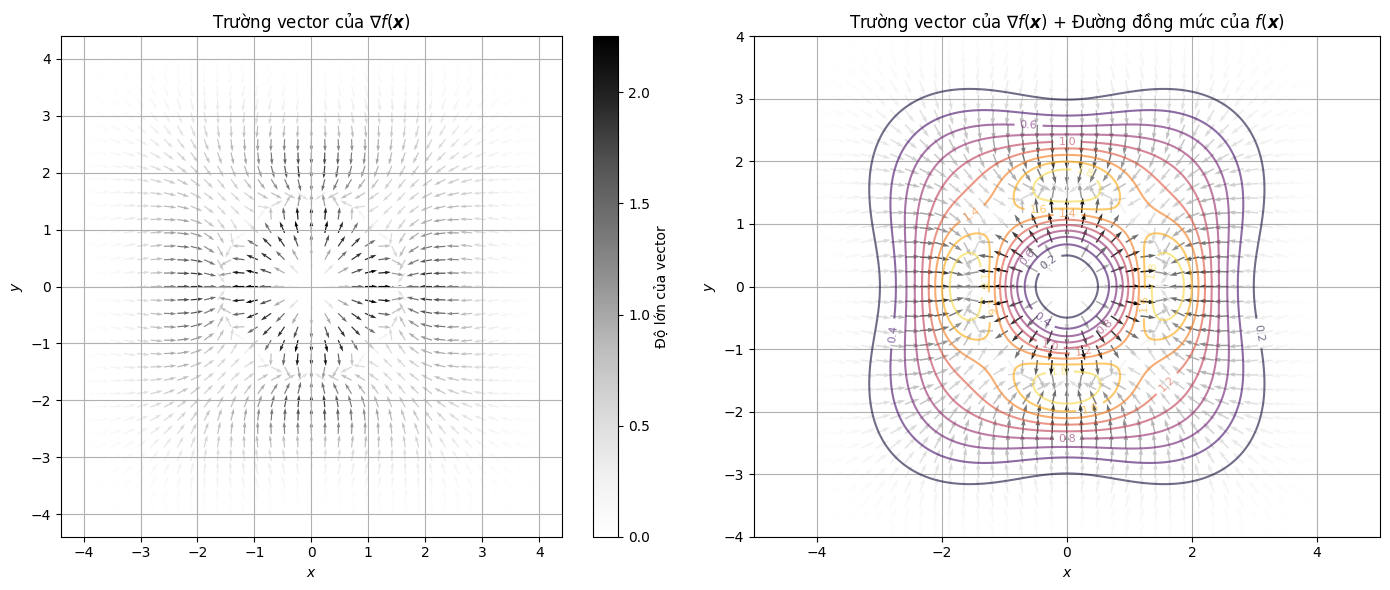

In [9]:
plot_function_derivative_vector_field()

### Phần 1: Cài đặt hàm $f(\mathbf x)$

In [10]:
def f(x: np.ndarray) -> float:
    x_val, y_val = x[0], x[1]
    term1 = np.sin(3 * np.exp( - (x_val**2 + y_val**2 + x_val*y_val)/4 )) ** 2
    term2 = np.sin(3 * np.exp( - (x_val**2 + y_val**2 - x_val*y_val)/4 )) ** 2
    return term1 + term2

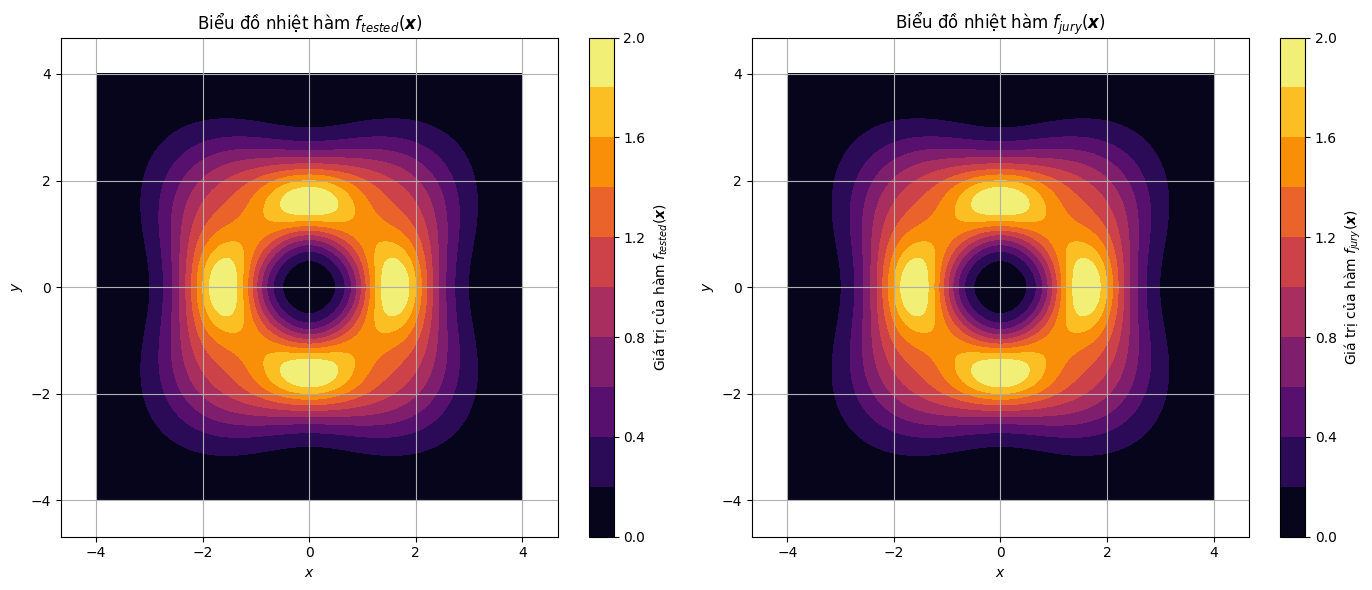

In [11]:
test_function_contour(f)

### Phần 2: Cài đặt hàm $\nabla f(\mathbf x)$

Phần bài tập này sẽ có yêu cầu đặc biệt. Để làm quen với việc tính gradient của một hàm (ví dụ như một Neural Network), bài tập sẽ yêu cầu bạn cài đặt hàm `grad_f` bằng thư viện `torch`, cụ thể là với "framework" `torch.autograd`. Tuy nhiên, bài tập này sẽ không ảnh hưởng đến [Bài tập 3](#bài-tập-3), chi tiết xem tại nội dung bài tập vừa được đề cập.

<div style='background-color: #e6f7ff; padding: 15px; border-radius: 5px; margin-bottom: 20px; color: black; border-left: 5px solid #1890ff;'>    
    <h3 style='margin: 0; color: #1890ff;'>ℹ️ <code>torch.autograd</code></h3>
    <p>Để tìm hiểu thêm về cách sử dụng <code>torch.autograd</code>, bạn có thể tham khảo tại
        <a href='https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html' target='_blank'>Trang chủ PyTorch - <code>torch.autograd</code></a>.
    </p>
    <p>
        Cụ thể hơn bạn có thể tập trung đọc tại:
    </p>
    <ul>
        <li><a href='https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#differentiation-in-autograd' target='_blank'>Differentiation in Autograd.</li>
        <li><a href='https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#optional-reading-vector-calculus-using-autograd' target='_blank'>Optional Reading - Vector Calculus using <code>autograd</code></a>.</li>
    </ul>
</div>

<div style='background-color: #ffcccc; padding: 15px; border-radius: 5px; margin-bottom: 20px; color: black; border-left: 5px solid red;'>
    <h3 style='margin: 0; color: red;'>❗ Cảnh báo</h2>
    <p>Hãy cẩn thận với kiểu dữ liệu truyền vào và kiểu dữ liệu trả về!</p>
</div>

In [12]:
import torch

# def grad_f(x: np.ndarray) -> np.ndarray:
#     """
#     Tính đạo hàm của hàm tỷ lệ thuận với hàm mật độ xác suất mục tiêu $p(x)$
#     """
#     # TODO: Hãy hoàn thành hàm này
#     if x.ndim == 1:
#         x = x.reshape(2, 1)
#     grad = np.zeros_like(x, dtype=np.float64)

#     for i in range(x.shape[1]):

#         point = torch.tensor(x[:, i], dtype=torch.float64, requires_grad=True)
#         term1 = torch.sin(3 * torch.exp(-(point[0]**2 + point[1]**2 + point[0]*point[1])/4))**2
#         term2 = torch.sin(3 * torch.exp(-(point[0]**2 + point[1]**2 - point[0]*point[1])/4))**2
#         f_torch = term1 + term2
#         f_torch.backward()
#         grad[:, i] = point.grad.numpy()
#         if point.grad is not None:
#             point.grad.zero_()
#     if x.shape[1] == 1:
#         grad = grad[:, 0]
#     return grad

def grad_f(x: np.ndarray) -> np.ndarray:
    """
    Tính đạo hàm của hàm tỷ lệ thuận với hàm mật độ xác suất mục tiêu p(x)
    mà không dùng vòng lặp for.
    """
    if x.ndim == 1:
        x = x.reshape(2, 1)
    x_tensor = torch.tensor(x.T, dtype=torch.float64, requires_grad=True)  # shape: (N, 2)

    x0 = x_tensor[:, 0]
    x1 = x_tensor[:, 1]

    exp1 = torch.exp(-(x0**2 + x1**2 + x0*x1) / 4)
    exp2 = torch.exp(-(x0**2 + x1**2 - x0*x1) / 4)

    term1 = torch.sin(3 * exp1)**2
    term2 = torch.sin(3 * exp2)**2
    f = term1 + term2

    f.sum().backward()  # tổng để backward một lần

    grad = x_tensor.grad.T.numpy()
    if grad.shape[1] == 1:
        grad = grad[:, 0]
    return grad

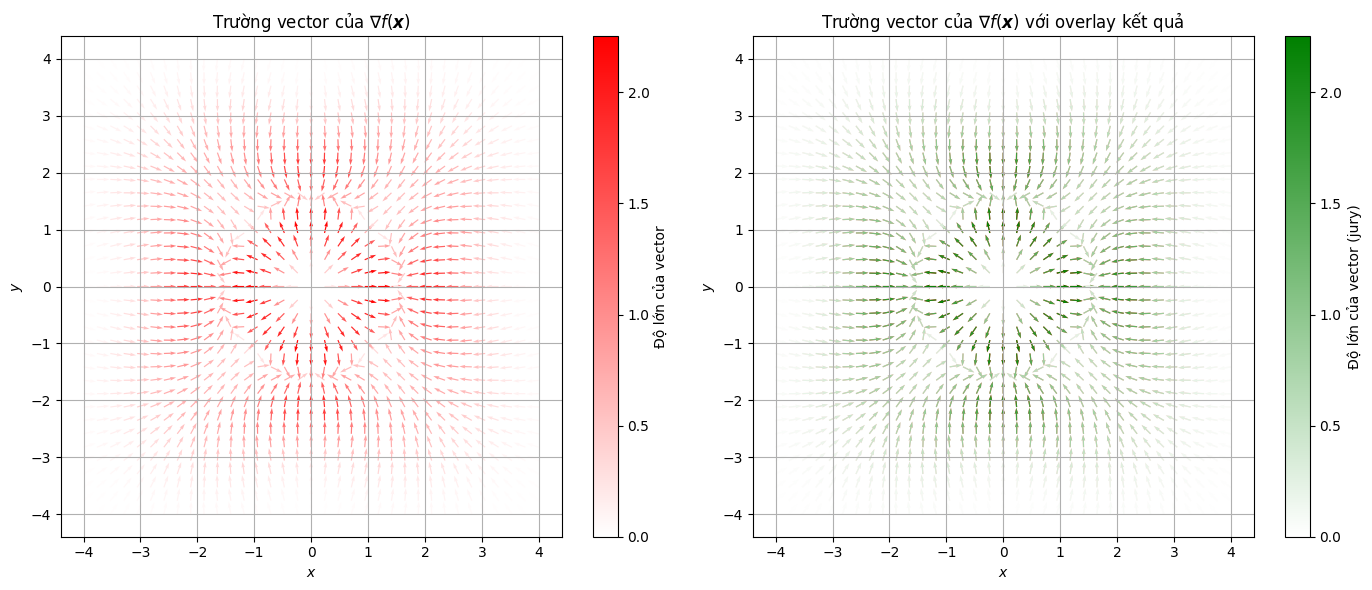

In [13]:
test_function_derivative_vector_field(grad_f)

# Bài tập 3

### Import trình chấm

In [14]:
from grader_homework_3.grade_p3 import plot_samples_with_contour, grad_f_fast

### Nội dung

Trong bài tập này, học viên được yêu cầu hoàn thành hàm `MALASampler.sample()` trong lớp `MALASampler` để thực hiện thuật toán Metropolis-adjusted Langevin algorithm nhằm lấy mẫu ngẫu nhiên từ phân phối $p(\mathbf x)$ tỷ lệ thuận với hàm $f(\mathbf x)$ được định nghĩa trong [Bài tập 2](#bài-tập-2).

Các phần cài đặt về tham số truyền vào đã được thực hiện sẵn, học viên có thể thay đổi các thiết lập của lớp `MHSampler` tùy ý, tuy nhiên điều này không được khuyến khích nếu không cần thiết.

Trong phần bài tập này, bằng phép thuật PIMA (viết tắt cho **P**rovably-efficient **I**mplementation for **M**ala **A**utodifferentiation), trình chấm đã cho trước hàm `grad_f_fast` ($\nabla f(\mathbf x)$) với tốc độ chạy nhanh hơn, vì thế bạn có thể không cần hoàn thành [Bài tập 2 - Phần 2](#phần-2-cài-đặt-hàm) để có thể hoàn thành bài tập này. Tuy nhiên việc hoàn thành tất cả bài tập vẫn được khuyến khích.

Với hàm $f(\mathbf x)$ cụ thể của bài tập này, phép thuật PIMA đã có thể tìm ra được cách cài đặt $\nabla f(\mathbf x)$ nhanh hơn so với việc sử dụng đồ thị tính toán của `torch.autograd`, tuy nhiên trong trường hợp tham số đầu vào có nhiều hơn 2 tham số và việc tính hàm $f(\mathbf x)$ phức tạp hơn, việc sử dụng `torch.autograd` sẽ nhanh và dễ dàng lập trình hơn! (Về chi tiết phép thuật PIMA, hãy gửi câu hỏi đến QnA chính thức của khóa học)

### Cài đặt Metropolis-adjusted Langevin algorithm sampler

In [15]:
class MALASampler(Generic[T]):
    def __init__(
        self,
        x0 : T,
        f : Callable[[T], float],
        grad_f : Callable[[T], np.ndarray],
        eta : float,
    ):
        """
        Metropolis-adjusted Langevin algorithm (MALA) Sampler

        Thực hiện lấy mẫu từ phân phối mục tiêu $p(x)$ thông qua phân phối đề xuất $q(x'|x)$

        Parameters
        ----------
        x0 : T
            Trạng thái khởi tạo được lấy mẫu từ phân phối tiền nghiệm
        f : (T) -> float
            Hàm tỷ lệ thuận với hàm mật độ xác suất mục tiêu $p(x)$
        grad_f : (T) -> np.ndarray
            Gradient của hàm $f(x)$ tỷ lệ thuận với hàm mật độ xác suất mục tiêu $p(x)$
        eta : float
            Tham số thời gian điều chỉnh, ảnh hưởng đến độ phân tán của mẫu
        """
        self.x_current = x0
        self.f = f
        self.grad_f = grad_f
        self.eta = eta

    def burn_in(self, steps: int) -> None:
        """
        Thực hiện bước "burn-in" để loại bỏ các mẫu không cần thiết

        Parameters
        ----------
        steps : int
            Số bước "burn-in" cần thực hiện
        """
        for _ in tqdm(range(steps), desc='Burning in'):
            self.sample()

    def sample(self):
        x_current = self.x_current
        f_current = self.f(x_current)
        grad_f_current = self.grad_f(x_current)
        grad_log_p_current = grad_f_current / f_current
        mu_proposed = x_current + (self.eta / 2) * grad_log_p_current
        z = np.random.normal(0, 1, size=2)
        x_proposed = mu_proposed + np.sqrt(self.eta) * z
        f_proposed = self.f(x_proposed)
        if f_proposed > 0:
            grad_f_proposed = self.grad_f(x_proposed)
            grad_log_p_proposed = grad_f_proposed / f_proposed
            mu_current = x_proposed + (self.eta / 2) * grad_log_p_proposed
            diff_current = x_current - mu_current
            diff_proposed = x_proposed - mu_proposed
            log_q_ratio = - (1 / (2 * self.eta)) * (np.sum(diff_current**2) - np.sum(diff_proposed**2))
            alpha = min(1, (f_proposed / f_current) * np.exp(log_q_ratio))
        else:
            alpha = 0
        u = np.random.uniform(0, 1)
        if u < alpha:
            self.x_current = x_proposed
        return self.x_current

### Thiết lập lấy mẫu

In [16]:
# Khởi tạo Metropolis-adjusted Langevin algorithm Sampler
mala_sampler = MALASampler[np.ndarray](
    x0=np.array([0., 2.]),
    f=f,
    grad_f=grad_f_fast,
    eta=0.574
)

# Pha "burn-in"
mala_sampler.burn_in(1_000)

# Pha lấy mẫu
p3_samples = [
    mala_sampler.sample()
    for _ in tqdm(range(500_000), desc='Metropolis-adjusted Langevin algorithm')
]

Metropolis-adjusted Langevin algorithm: 100%|██████████| 500000/500000 [00:21<00:00, 23442.51it/s]


### Vẽ biểu đồ nhiệt các điểm đã lấy mẫu cùng biểu đồ đường đồng mức của hàm $f(\mathbf x)$

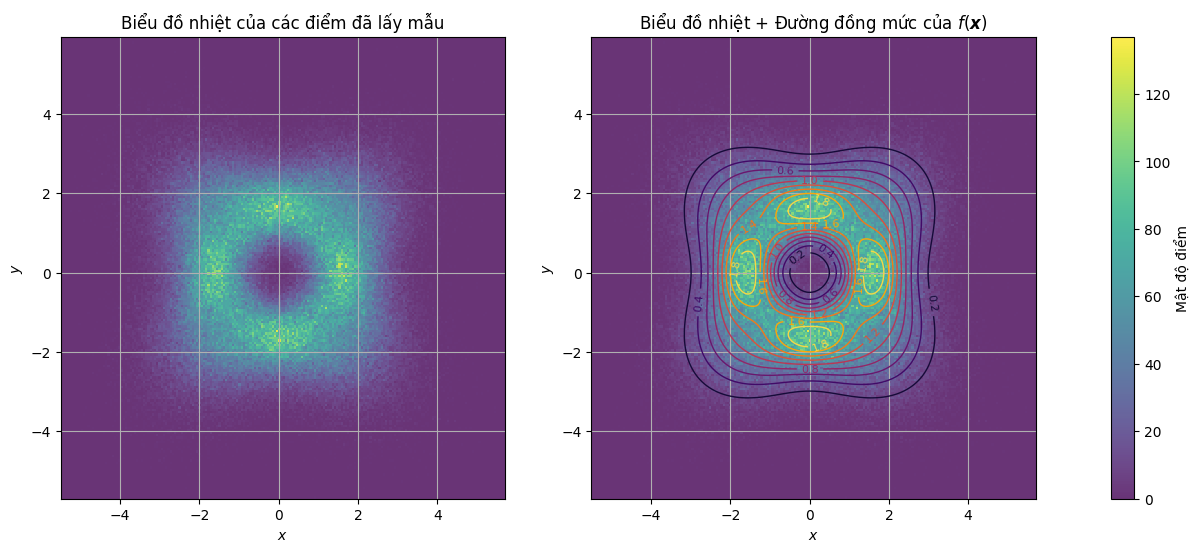

In [17]:
plot_samples_with_contour(f, p3_samples)

### Bonus: Lấy mẫu bằng MHSampler để kiểm tra tính đúng đắn

In [18]:
mh_sampler = MHSampler[np.ndarray](
    x0=np.array([0., 2.]),
    q_sampler=lambda x: (x[0] + np.random.normal(0, 1), x[1] + np.random.normal(0, 1)),
    f=f,
    # q=lambda x, y: np.exp(-((x[0]-y[0])**2 + (x[1]-y[1])**2) / (2 * std**2)),
    is_symmetric=True
)

# Burn-in phase
mh_sampler.burn_in(1_000)
# Sampling phase
p3_samples_mh = [
    mh_sampler.sample()
    for _ in tqdm(range(1_000_000), desc='Metropolis-Hastings Sampling')
]

Metropolis-Hastings Sampling: 100%|██████████| 1000000/1000000 [00:05<00:00, 197793.26it/s]


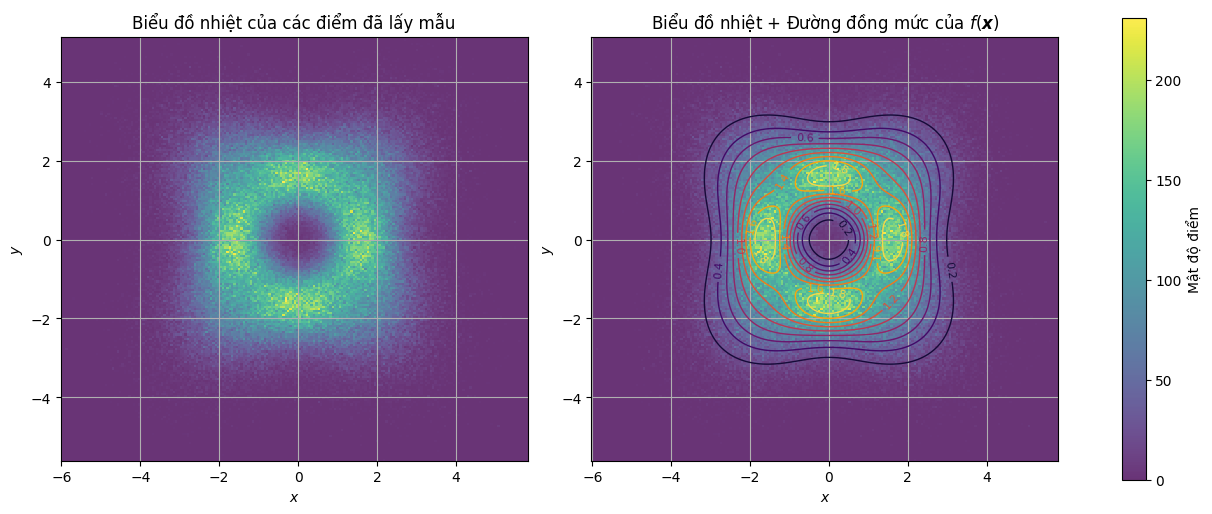

In [19]:
plot_samples_with_contour(f, p3_samples_mh)